In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


In [48]:
df_train = pd.read_csv('train.csv')
df_train.head(100)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,0.0,17.0,Arlen Mclainez,True
96,0103_02,Earth,True,G/18/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,Shaele Mclainez,True
97,0103_03,Earth,True,G/18/S,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,Fanne Mclainez,False
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,Carry Cleachrand,False


In [49]:
#how many numerical features do you have?
df_train.info() #look at data structure and variable types in dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [50]:
len(df_train) #number of obesrvations in dataset

8693

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<function matplotlib.pyplot.legend>

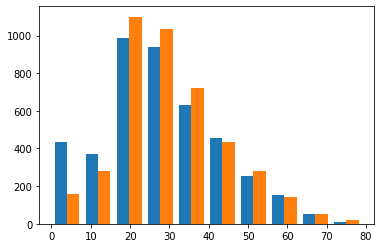

In [51]:
plt.hist([df_train.Age[df_train.Transported == True], df_train.Age[df_train.Transported == False]],
         bins = 10,
         label = ['Transported', 'Not transported'])
plt.legend

In [52]:
#Which HomePlanet has the highest percentage of Transported passengers
# df_train.groupby('HomePlanet').apply(len) ## possible but slower option
df_train['HomePlanet'].value_counts() # counts both transported and not trans.

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [53]:
df_train[(df_train.Transported == True)]['HomePlanet'].value_counts() #counts categorical values for Transported only

Earth     1951
Europa    1404
Mars       920
Name: HomePlanet, dtype: int64

In [54]:
df_train[(df_train.Transported == True)]['HomePlanet'].value_counts() / df_train['HomePlanet'].value_counts() # calculate percentage

Earth     0.423946
Europa    0.658846
Mars      0.523024
Name: HomePlanet, dtype: float64

In [55]:
#Does CryoSleep increase the chances of being Transported?
len(df_train[(df_train.Transported == True)&(df_train.CryoSleep == True)])

2483

In [56]:
df_train.CryoSleep.dropna() #8476
# 2483 / 8476

0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689     True
8690    False
8691    False
8692    False
Name: CryoSleep, Length: 8476, dtype: object

In [57]:
# Construct a simple pipeline: Impute missing values (for numerical features use 0, except for Age, for Age use mean imputation;
# for categorical features impute with the most frequent value), Standardize numerical features (zero mean and unit variance), 
# Use KNN with 10 neighbors. 
# Use 3-fold cross-validation. What is your average classification accuracy? (integer number 0-100)

In [58]:
# Insert 0 for NA numeric values
x = df_train.describe(include = 'float64').columns.tolist()
x.remove('Age')

for column in df_train[x]:
    df_train[column].fillna(0, inplace=True)

In [59]:
# Impute mean for Age
mean_age = df_train.Age.mean()
df_train.Age = df_train.Age.fillna(mean_age)

In [60]:
# Insert most frequent values for NA categorical values
x = df_train.describe(include = 'object').columns.tolist()

for column in df_train[x]:
    mod = df_train[column].mode()
    df_train[column].fillna(mod[0], inplace=True) #need indexing for "mod" because .mode() gives Series output

In [61]:
# Scale numeric data
scaler = StandardScaler()
x = df_train.describe(include = 'float64').columns.tolist()

scaler.fit(df_train[x])
df_train[x] = scaler.transform(df_train[x])

In [62]:
## Convert categorical to dummies
df_train = pd.get_dummies(df_train.drop(['PassengerId','Cabin','Destination','Name'], axis = 1), 
                        columns=['CryoSleep','VIP','HomePlanet'])
df_train.head(3)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0.709437,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,False,1,0,1,0,0,1,0
1,-0.336717,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,True,1,0,1,0,1,0,0
2,2.034566,-0.268001,1.959998,-0.283579,5.695623,-0.219796,False,1,0,0,1,0,1,0


In [63]:
# Use KNN with 10 neighbors. 
# Use 3-fold cross-validation.
preds = df_train.columns.values.tolist()
preds.remove('Transported')

X_train, y_train = df_train[preds], df_train['Transported']
knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=10)

In [64]:
from sklearn.metrics import accuracy_score

In [65]:
y_pred_train = knn_clf.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.7968480386517888

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


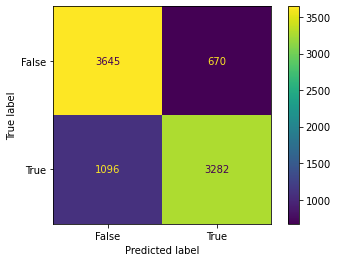

In [67]:
# Confusion matrix for model without cross-validation
plot_confusion_matrix(knn_clf, X_train, y_train) 
plt.show()

In [68]:
# Scores with 3 cross-validation folds
scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
scores.mean()

0.7648688476906574

In [69]:
## At the moment I don't really understand why this method's result slightly differs from the previous cell
# although here it's said that it is possible: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
y_pred_cross = cross_val_predict(knn_clf, X_train, y_train, cv=3)
accuracy_score(y_train, y_pred_cross)

0.7648682848268722

In [72]:
# Confusion matrix for cross-validated data
y_pred_cross = cross_val_predict(knn_clf, X_train, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_pred_cross)
conf_mat


array([[3447,  868],
       [1176, 3202]])

In [25]:
#Specificity (True Negative Rate): TN / N = TN/(TN+FP)
3447 / (3447 + 868)

0.7988412514484357

In [26]:
#Sensitivity (True Positive Rate): TP/P = TP/(TP+FN)
3202 / (3202+1176)

0.7313841936957515

In [27]:
#different values of k for KNN: 3, 5, 10, 15, 30, 50

acc_train = []

for k in [3, 5, 10, 15, 30, 50]:
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    
    y_pred_cross = cross_val_predict(model, X_train, y_train, cv=3)
   
    acc_train.append(accuracy_score(y_train, y_pred_cross))

In [28]:
acc_train #0.7830438283676522 k=30 the best 

[0.7488784079144138,
 0.7575060393419993,
 0.7648682848268722,
 0.7760266881398826,
 0.7830438283676522,
 0.7820085125963419]

In [29]:
# Detecting the lowest False Positives
#different values of k for KNN: 3, 5, 10, 15, 30, 50

FP_train = []

for k in [3, 5, 10, 15, 30, 50]:
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    
    y_pred_cross = cross_val_predict(model, X_train, y_train, cv=3)
   
    FP_train.append(confusion_matrix(y_train, y_pred_cross)[0][1])


In [30]:
FP_train #868, k=10 the lowest FP

[989, 957, 868, 1042, 1002, 1030]

#**Test data**

In [31]:
df_test = pd.read_csv('test.csv')
df_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


In [32]:
# Insert 0 for NA numeric values
x = df_test.describe(include = 'float64').columns.tolist()
x.remove('Age')

for column in df_test[x]:
    df_test[column].fillna(0, inplace=True)

In [33]:
# Impute mean for Age
mean_age = df_test.Age.mean()
df_test.Age = df_test.Age.fillna(mean_age)

In [34]:
# Insert most frequent values for NA categorical values
x = df_test.describe(include = 'object').columns.tolist()

for column in df_test[x]:
    mod = df_test[column].mode()
    df_test[column].fillna(mod[0], inplace=True) #need indexing for "mod" because .mode() gives Series output

In [35]:
# Scale numeric data
scaler = StandardScaler()
x = df_test.describe(include = 'float64').columns.tolist()

scaler.fit(df_test[x])
df_test[x] = scaler.transform(df_test[x])

In [36]:
## Convert categorical to dummies
df_test = pd.get_dummies(df_test.drop(['PassengerId','Cabin','Destination','Name'], axis = 1), 
                        columns=['CryoSleep','VIP','HomePlanet'])
df_test.head(3)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,-0.118222,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,0,1,1,0,1,0,0
1,-0.688601,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,1,0,1,0,1,0,0
2,0.166968,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,0,1,1,0,0,1,0


In [37]:
df_test['Transported'] = ""
df_test.head(3)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Transported
0,-0.118222,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,0,1,1,0,1,0,0,
1,-0.688601,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,1,0,1,0,1,0,0,
2,0.166968,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,0,1,1,0,0,1,0,


In [38]:
X_test, y_test = df_test[preds], df_test['Transported']

knn_clf = KNeighborsClassifier(n_neighbors=30)
knn_clf.fit(X_train, y_train)

y_pred_test = knn_clf.predict(X_test)

In [39]:
y_pred_test

array([ True, False,  True, ...,  True,  True,  True])

In [40]:
df_test2 = pd.read_csv('test.csv')
indexes = df_test2.PassengerId.tolist()
cols = ['prediction']
df_final = pd.DataFrame(data = y_pred_test, 
                  index = indexes, 
                  columns = cols)
df_final

,prediction
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,False
9271_01,True
9273_01,True


In [ ]:
from google.colab import files
df_final.to_csv('test.csv', sep = ',')
files.download('test.csv')
# my first attempt on the Kaggle's leaderboard is 0.77998

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>